# RNA pulse 3.6c substance independent

The model RNA-pulse describes the damage dynamic as a expression pulse. It uses a sigmoid function to model the threshold dependent activation of *Nrf2* expression and a concentration dependent exponential decay of RNA molecules. Coupled with active metabolization of the internal concentration of the chemical this leads to a pulse like behavior. In addition *Nrf2* serves as a proxy for toxicodynamic damage

## 💥 Attention

1. When calculating treatment effects it should be made sure that effects are calculated differentially to the initial value of the RNA expression
2. When $R_0 \neq 1$, the RNA expression has to be divided by the baseline to obtain fold-change values, after the ODE has been solved.


## Imports

First, I apply some modifications to the jupyter notebook for a cleaner experience.
Warnigns are ignored, the root directory is changed to the base of the repository.
Then relevant packages are imported for the case study and its evaluation

In [2]:
import os
import json
import warnings
from functools import partial

import numpy as np
import arviz as az
import matplotlib as mpl
from matplotlib import pyplot as plt

from pymob.utils.store_file import prepare_casestudy

warnings.filterwarnings("ignore")
os.chdir("/home/flo-schu/projects/damage-proxy")

In [3]:
config = prepare_casestudy(
    case_study=("tktd_rna_pulse", "rna_pulse_3_6c_substance_specific"),
    config_file="settings.cfg"
)
from case_studies.tktd_rna_pulse.sim import SingleSubstanceSim2
from case_studies.tktd_rna_pulse.prob import model_rna_pulse_3_6c_substance_independent_rna_protein_module
from case_studies.tktd_rna_pulse.mod import tktd_rna_3_6c

In [4]:
# Knapp data are IDs 37, 38, 39
sim = SingleSubstanceSim2(config=config)

sim.model = tktd_rna_3_6c

MinMaxScaler(variable=cext, min=0.0, max=514.382187237679)
MinMaxScaler(variable=cint, min=0.0, max=6364.836264471382)
MinMaxScaler(variable=nrf2, min=0.0, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)


## Parameter inference

Parameter inference estimates the value of the parameters given the data 
presented to the model.

Here we calculate a maximum a posteriori (MAP) estimate which is the mode
of the posterior distribution.

In [6]:
# set up the inferer properly
sim.coordinates["time"] = sim.observations.time.values
sim.set_inferer("numpyro")


First of all prior predictions are generated. These are helpful to diagnose
the model and also to compare posterior parameter estimates with the prior
distributions. If there is a large bias, this information can help to achieve
a better model fit. We can speed up the prior predictive sampling, if we let
the model only sample the prior distributions `only_prior=True`

In [8]:
# set the inference model
sim.coordinates["time"] = sim.observations.time.values
sim.inferer.inference_model = partial(model_rna_pulse_3_6c_substance_independent_rna_protein_module, only_prior=True)

# prior predictions
seed = int(np.random.random_integers(0, 100, 1))
prior_predictions = sim.inferer.prior_predictions(n=4000, seed=seed)

C_{i, max}: [1757.0, 168.1, 6364.8]


In the next step, we take the full model, including deterministic ODE solution
and error model and run our MAP estimator on it, with the parameters that have
been setup before.

C_{i, max}: [1757.0, 168.1, 6364.8]
       Trace Shapes:         
        Param Sites:         
       Sample Sites:         
       k_i_norm dist      3 |
               value      3 |
       k_m_norm dist      3 |
               value      3 |
      z_ci_norm dist      3 |
               value      3 |
      r_rt_norm dist      1 |
               value      1 |
      r_rd_norm dist      1 |
               value      1 |
       k_p_norm dist      1 |
               value      1 |
         z_norm dist      1 |
               value      1 |
      v_rt_norm dist      1 |
               value      1 |
       h_b_norm dist      1 |
               value      1 |
        kk_norm dist      1 |
               value      1 |
sigma_cint_norm dist      1 |
               value      1 |
sigma_nrf2_norm dist      1 |
               value      1 |
       cint_obs dist 202 23 |
               value 202 23 |
       nrf2_obs dist 202 23 |
               value 202 23 |
   survival_obs dist 202 23 |
    

100%|██████████| 2000/2000 [00:50<00:00, 39.48it/s, init loss: 4429.8447, avg. loss [1901-2000]: 3031.1997]
arviz - WARNING - Shape validation failed: input_shape: (1, 1), minimum_shape: (chains=1, draws=4)


                mean  sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h_b[0]         0.000 NaN   0.000    0.000        NaN      NaN       NaN   
k_i[0]         4.444 NaN   4.444    4.444        NaN      NaN       NaN   
k_i[1]         0.450 NaN   0.450    0.450        NaN      NaN       NaN   
k_i[2]         0.227 NaN   0.227    0.227        NaN      NaN       NaN   
k_m[0]         1.594 NaN   1.594    1.594        NaN      NaN       NaN   
k_m[1]         0.145 NaN   0.145    0.145        NaN      NaN       NaN   
k_m[2]         0.012 NaN   0.012    0.012        NaN      NaN       NaN   
k_p[0]         0.009 NaN   0.009    0.009        NaN      NaN       NaN   
kk[0]          0.041 NaN   0.041    0.041        NaN      NaN       NaN   
r_rd[0]        0.807 NaN   0.807    0.807        NaN      NaN       NaN   
r_rt[0]        1.634 NaN   1.634    1.634        NaN      NaN       NaN   
sigma_cint[0]  1.740 NaN   1.740    1.740        NaN      NaN       NaN   
sigma_nrf2[0]  0.216 NaN 

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

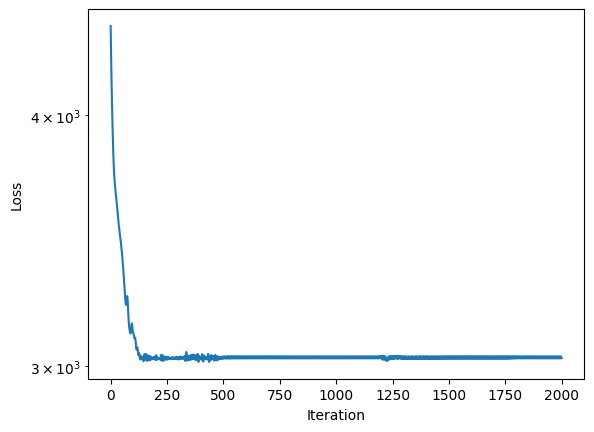

In [9]:
# set the inference model
sim.config.set("inference.numpyro", "kernel", "map")
sim.config.set("inference.numpyro", "svi_iterations", "5000")
sim.config.set("inference.numpyro", "svi_learning_rate", "0.01")
sim.coordinates["time"] = sim.observations.time.values
sim.inferer.inference_model = partial(model_rna_pulse_3_6c_substance_independent_rna_protein_module, only_prior=False)
sim.inferer.run()

# show (and explore idata)
sim.inferer.idata

## Posterior predictions

In order to evaluate the goodness of fit for the posteriors, we are looking
at the posterior predictions.

In order to obtain smoother trajectories, the time resolution is increased,
and posterior predictions are calculated.

In [10]:
sim.coordinates["time"] = np.linspace(24, 120, 100)
seed = int(np.random.random_integers(0, 100, 1))

res = sim.inferer.posterior_predictions(n=1, seed=seed).mean(("draw", "chain"))
res

Posterior predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Posterior predictions: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


<xarray.Dataset>
Dimensions:    (id: 202, time: 100)
Coordinates:
  * id         (id) object '101_0' '101_1' '106_0' ... '66_4' '66_5' '6_0'
  * time       (time) float64 24.0 24.97 25.94 26.91 ... 117.1 118.1 119.0 120.0
Data variables:
    P          (id, time) float32 0.0 0.0004881 0.001578 ... 0.5943 0.6044
    cext       (id, time) float32 2.34 2.34 2.34 2.34 ... 349.5 349.5 349.5
    cint       (id, time) float32 0.0 10.08 20.14 ... 6.42e+03 6.453e+03
    lethality  (id, time) float32 0.0 0.0 0.0 0.0 ... 0.8892 0.8952 0.9009
    nrf2       (id, time) float32 1.0 1.103 1.151 1.174 ... 2.79 2.793 2.796
    survival   (id, time) float32 1.0 1.0 1.0 1.0 ... 0.1108 0.1048 0.09913

Next, we plot the predictions against selected experiments. Note that the observations,
may be slightly diverging from the MAP predictions, because
a) the model is not completely correct
b) other data *pull* the posterior estimate away from the displayed data.

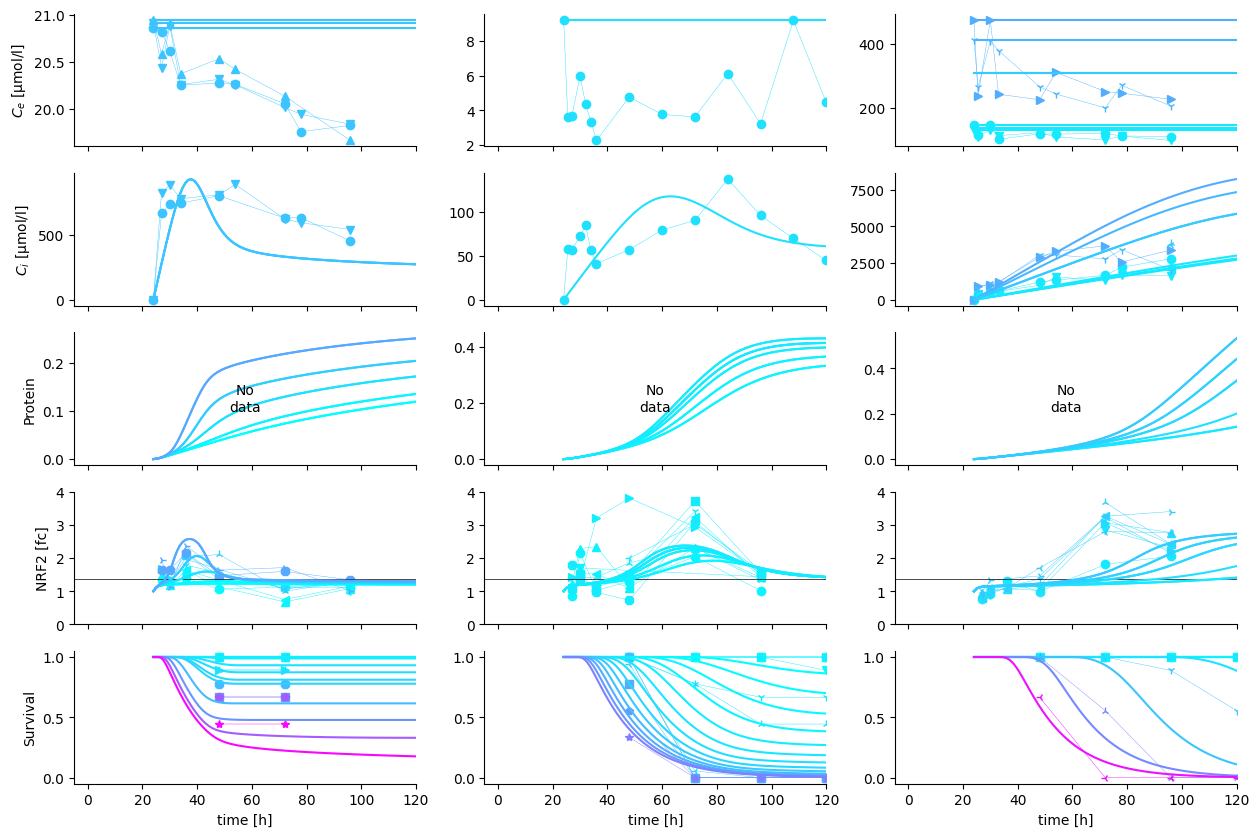

In [12]:
with open(sim.scenario_path + "/experiment_selection_1.json", "r") as fp:
    data_structure = json.load(fp)
    
res = res.assign_coords({"substance": sim.observations.substance})
cmap = mpl.colormaps["cool"]
fig, axes = plt.subplots(len(data_structure), 3, sharex=True, figsize=(15,10))


for r, (v, vdict) in enumerate(data_structure.items()):
    for c, (s, sdict) in enumerate(vdict["substances"].items()):
        sdata = sim.observations.where(sim.observations.substance == s, drop=True)
        C = np.round(sdata.cext_nom.values, 1)
        norm = mpl.colors.Normalize(vmin=C.min(), vmax=C.max())
        for eid in sdict["experiment_ids"]:

            ax, meta, obs_ids, _ = sim.mplot.plot_experiment(
                self=sim,
                experiment_id=eid,
                substance=s,
                data_var=v,
                cmap=cmap,
                norm=norm,
                ax=axes[r, c]
            )

            if v != "survival":
                ax.set_xlabel("")

            if v == "P":
                ax.set_ylabel("Protein")
                ax.spines[["right", "top"]].set_visible(False)

            if v == "nrf2":
                ax.set_ylim(0, 4)
                # note that the thresholds are mixed up. Diuron and Diclofenac should swap
                z = sim.inferer.idata.posterior.z.mean(("chain", "draw")).values
                ax.hlines(z, -10, 120, color="black", lw=0.5)

            if c != 0:
                ax.set_ylabel("")

            l = ax.get_legend()
            if l is not None:
                l.remove()
            ax.set_title("")

            res_ids = sim.get_ids(res, {"substance": s, "experiment_id": eid})

            for i in res_ids:
                y = res.sel(id=i)
                ax.plot(res.time, y[v], color=cmap(norm(y.cext.isel(time=0))))


In the combined model (tktd_rna_3_1), especially NRF2 of Naproxen converges on an
incorrect model dynamic. This is caused (I'm sure) by the substance-indepdendent
threshold parameter $z$ and killing rate $k_k$

## Compare prior and posterior distributions to diagnose biases

We can also look at the prior distributions and the MAP estimate of the posterior
parameter distribution, to assess, whether we are influencing the fit by 
providing a prior that is very far away from the posterior estimate.

In this case-study, the priors should have only a small effect, because of the
large amount of data. Still it is better to be sure.

Since, the parameters are on vastly different scales, they are displayed on the
log-axis.

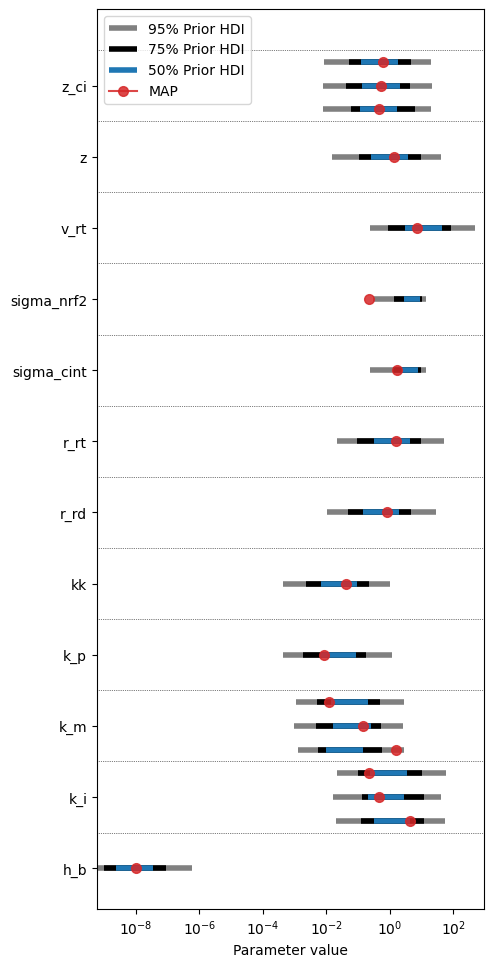

In [13]:
# mpl.use('TkAgg')

substances = sim.observations.attrs["substance"]
priors = prior_predictions.prior.stack(sample=("chain", "draw"))
posteriors = sim.inferer.idata.posterior

hdi_priors_50 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.50))
hdi_priors_75 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.75))
hdi_priors_95 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.95))

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

prior_names = list(priors.data_vars.keys())
xmax = hdi_priors_95.max().to_array().max() * 2
xmin = hdi_priors_95.min().to_array().min() * 2

for k, (key, prior) in enumerate(priors.data_vars.items()):
    nsubstance = len(prior.coords[f"{key}_dim_0"])
    for i in range(nsubstance):
        if nsubstance == 1:
            y = 1
        else:
            y = i

        y_ = k + (y/3 - 1/3)
        h95 = hdi_priors_95[key].isel({f"{key}_dim_0": i})
        h75 = hdi_priors_75[key].isel({f"{key}_dim_0": i})
        h50 = hdi_priors_50[key].isel({f"{key}_dim_0": i})
        posterior_estimate = posteriors[key].mean(("chain", "draw"))
        map_ = posterior_estimate.isel({f"{key}_dim_0": i})

        ax.hlines(y_, *h95, lw=4, color="grey")
        ax.hlines(y_, *h75, lw=4, color="black")
        ax.hlines(y_, *h50, lw=4, color="tab:blue")
        ax.plot(map_, y_, color="tab:red", ms=7, alpha=.85, marker="o")
        if i == 0:
            ax.hlines(k + 0.5, xmin, xmax, ls="dotted", lw=.5, color="black")

ax.set_xscale("log")
ax.set_xlabel("Parameter value")
ax.set_yticks(range(len(prior_names)))
ax.set_yticklabels(prior_names, minor=False)
ax.set_xlim(xmin, xmax)
ax.hlines([], [], [], lw=4, color="grey", label="95% Prior HDI")
ax.hlines([], [], [], lw=4, color="black", label="75% Prior HDI")
ax.hlines([], [], [], lw=4, color="tab:blue", label="50% Prior HDI")
ax.plot([], [], ms=7, alpha=.85, marker="o", color="tab:red", label="MAP")
ax.legend()

fig.subplots_adjust(top=0.95, bottom=0.05)
fig.savefig(f"{sim.output_path}/prior_posterior.png")